# HCAA Testing and creation of portfolios

In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import kneed
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
from sklearn.metrics import calinski_harabasz_score
from hcaa_implementation import hcaa_alocation
import rie_estimator
import csestimator

## Definition of aux functions

In [144]:
def get_optimal_k_eigen(corr_matrix, N, T):
    eigenvals = np.linalg.eigvals(corr_matrix)
    count = (eigenvals > 1 + 2 * np.sqrt(N / T) + N / T).sum()
    return count

def get_optimal_k_calenski(dataset, bottom_range, top_range, corr_function):
    corr_mat = corr_function(dataset.T)
    D_matrix = np.sqrt(2 * (1 - corr_mat))
    D_matrix = np.around(D_matrix, decimals=7)
    D_condensed = ssd.squareform(D_matrix)
    Z = linkage(D_condensed, "ward", optimal_ordering=True)
    indices = []
    for i in range(bottom_range, top_range):
        labels = fcluster(Z, i, criterion="maxclust")
        indices.append(calinski_harabasz_score(dataset.T, labels))
    # pd.Series(indices).plot()
    print(
        kneed.KneeLocator(
            range(bottom_range, top_range),
            indices,
            curve="convex",
            direction="decreasing",
        ).knee
    )
    return kneed.KneeLocator(
        range(bottom_range, top_range), indices, curve="convex", direction="decreasing"
    ).knee


def get_optimal_k_calenski_rie(dataset, bottom_range, top_range, corr_function):
    corr_mat = corr_function(dataset)
    D_matrix = np.sqrt(2 * (1 - corr_mat))
    D_matrix = np.around(D_matrix, decimals=7)
    D_condensed = ssd.squareform(D_matrix)
    Z = linkage(D_condensed, "ward", optimal_ordering=True)
    indices = []
    for i in range(bottom_range, top_range):
        labels = fcluster(Z, i, criterion="maxclust")
        indices.append(calinski_harabasz_score(dataset.T, labels))
    print(
        kneed.KneeLocator(
            range(bottom_range, top_range),
            indices,
            curve="convex",
            direction="decreasing",
        ).knee
    )
    return kneed.KneeLocator(
        range(bottom_range, top_range), indices, curve="convex", direction="decreasing"
    ).knee

def get_levels(n_clusters: int, n_filas: int, mat_Z: np.matrix):
    nodos_id = []
    nivel_nodo = []
    filas_Z = mat_Z.shape[0]
    current_bif = mat_Z[-1]
    nodos_id.append(int(current_bif[0]))
    nivel_nodo.append(.5)
    nodos_id.append(int(current_bif[1]))
    nivel_nodo.append(.5)
    current_level = 2
    while(current_level < n_clusters):
        id_cluster = filas_Z+n_filas-current_level
        current_bif = mat_Z[-current_level]
        index_of_id = nodos_id.index(id_cluster)
        new_weight = nivel_nodo[index_of_id] / 2
        del nivel_nodo[index_of_id]
        del nodos_id[index_of_id]
        nodos_id.append(int(current_bif[0]))
        nivel_nodo.append(new_weight)
        nodos_id.append(int(current_bif[1]))
        nivel_nodo.append(new_weight)
        current_level += 1
    return(nodos_id, nivel_nodo)

## Reading and selecting data

In [145]:
precios_americano = pd.read_csv(
    "./sp_500_original_clean.csv",
    index_col="Date",
    parse_dates=True,
)

precios_europeo = pd.read_csv(
    "./european_market_original_clean.csv",
    index_col="Date",
    parse_dates=True,
)

retornos_american = (np.log(precios_americano) - np.log(precios_americano.shift(1))).iloc[1:]
retornos_europeo = (np.log(precios_europeo) - np.log(precios_europeo.shift(1))).iloc[1:]


Determinación de la última ventana de tiempo para ambos mercados

In [146]:
ultima_ventana_american = retornos_american[retornos_american.shape[0] - (retornos_american.shape[1]*2):]
ultima_ventana_european = retornos_europeo[retornos_europeo.shape[0] - (retornos_europeo.shape[1]*2):]

Los periodos comprendidos entre las ventanas son los siguientes:

Mercado americano: 2018-05-09 a 2021-12-30

Mercado europeo: 2019-10-17 a 2021-12-10

Reviso que el ratio óptimo para el RIE se mantenga, notando que sea de 1/2:

In [96]:
print(ultima_ventana_european.shape[1]/ultima_ventana_european.shape[0])
print(ultima_ventana_american.shape[1]/ultima_ventana_american.shape[0])

0.5
0.5


## Determinación de número óptimo de grupos

### Valores Propios

In [97]:
rie_estimator_american = rie_estimator.get_rie(ultima_ventana_american, True, True)
pearson_estimator_american = np.corrcoef(ultima_ventana_american.values.T)
eca_estimator_american = csestimator.get_shrinkage_est(ultima_ventana_american, alpha = 0.5)

k_optimal_eigen_american_rie = get_optimal_k_eigen(rie_estimator_american, ultima_ventana_american.shape[0], ultima_ventana_american.shape[1])
k_optimal_eigen_american_pearson = get_optimal_k_eigen(pearson_estimator_american, ultima_ventana_american.shape[0], ultima_ventana_american.shape[1])
k_optimal_eigen_american_eca = get_optimal_k_eigen(eca_estimator_american, ultima_ventana_american.shape[0], ultima_ventana_american.shape[1])

print('MERCADO AMERICANO')
print(k_optimal_eigen_american_rie)
print(k_optimal_eigen_american_pearson)
print(k_optimal_eigen_american_eca)


MERCADO AMERICANO
6
5
9


In [98]:
rie_estimator_european = rie_estimator.get_rie(ultima_ventana_european, False, True)
pearson_estimator_european = np.corrcoef(ultima_ventana_european.values.T)
eca_estimator_european = csestimator.get_shrinkage_est(ultima_ventana_european, alpha = 0.5)

k_optimal_eigen_european = get_optimal_k_eigen(rie_estimator_european, ultima_ventana_european.shape[0], ultima_ventana_european.shape[1])
k_optimal_eigen_european_pearson = get_optimal_k_eigen(pearson_estimator_european, ultima_ventana_european.shape[0], ultima_ventana_european.shape[1])
k_optimal_eigen_european_eca = get_optimal_k_eigen(eca_estimator_european, ultima_ventana_european.shape[0], ultima_ventana_european.shape[1])

print('MERCADO EUROPEO')
print(k_optimal_eigen_european)
print(k_optimal_eigen_european_pearson)
print(k_optimal_eigen_european_eca)

MERCADO EUROPEO
3
3
4


### Calenski

In [99]:
k_optimal_calenski_american_rie = get_optimal_k_calenski_rie(ultima_ventana_american, 2, 50, rie_estimator.get_rie)
k_optimal_calenski_american_pearson = get_optimal_k_calenski(ultima_ventana_american, 2, 50, np.corrcoef)
k_optimal_calenski_american_eca = get_optimal_k_calenski(ultima_ventana_american, 2, 50, np.corrcoef)

14
6
6


In [100]:
k_optimal_calenski_european_rie = get_optimal_k_calenski_rie(ultima_ventana_european, 2, 50, rie_estimator.get_rie)
k_optimal_calenski_european_pearson = get_optimal_k_calenski(ultima_ventana_european, 2, 50, np.corrcoef)
k_optimal_calenski_european_eca = get_optimal_k_calenski(ultima_ventana_european, 2, 50, np.corrcoef)

10
8
8


## DENDOGRAM

## Mercado Americano

In [152]:
import typing as t

In [155]:
def get_levels(n_clusters: int, n_filas: int, mat_Z: np.matrix):
    nodos_id = []
    nivel_nodo = []
    filas_Z = mat_Z.shape[0]
    current_bif = mat_Z[-1]
    nodos_id.append(int(current_bif[0]))
    nivel_nodo.append(.5)
    nodos_id.append(int(current_bif[1]))
    nivel_nodo.append(.5)
    current_level = 2
    while(current_level < n_clusters):
        id_cluster = filas_Z+n_filas-current_level
        current_bif = mat_Z[-current_level]
        index_of_id = nodos_id.index(id_cluster)
        new_weight = nivel_nodo[index_of_id] / 2
        del nivel_nodo[index_of_id]
        del nodos_id[index_of_id]
        nodos_id.append(int(current_bif[0]))
        nivel_nodo.append(new_weight)
        nodos_id.append(int(current_bif[1]))
        nivel_nodo.append(new_weight)
        current_level += 1
    distance_thershold = current_bif[2] - 0.000001
    return(nodos_id, nivel_nodo, distance_thershold)

def hacer_dendograma(data_set: pd.DataFrame, corr_est_func: t.Callable, link_name: str, num_grupos: int):
    E_matrix = corr_est_func(data_set)
    D_matrix = np.sqrt(2*(1- E_matrix))
    D_matrix = np.around(D_matrix, decimals=7)
    D_condensed = ssd.squareform(D_matrix)
    Z = linkage(D_condensed, link_name, optimal_ordering = True)
    fig = plt.figure(figsize=(35, 15))
    _, _, distancia = get_levels(num_grupos, data_set.shape[1], Z)
    dn = dendrogram(Z, color_threshold= distancia, labels=data_set.columns.to_numpy())
    return dn 


ME QUEDO ACÁ, HAY QUE USAR UNA VERSIÓN MODIFICADA DE GET_LEVELS PARA QUE REGRESE EL THRESHOLD (ESTE THRESHOLD HAY QUE REDONDEARLO UN POCO HACIA ABAJO) Y ESE THRESHOLD ES EL QUE HAY QUE USAR EN EL DENDOGRAMA PARA QUE SE COLOREEN CORRECTAMENTE LOS GRUPOS. 

REVISADO.  NOTAR QUE EL ENLACE DE WARD PUEDE PRODUCIR VALORES MAYORES A 2 PUES ESTÁ USANDO UNA FUNCIÓN PARA CALCULAR LA DISTANCIA ENTRE CLUSTERS (NO TIENE POR QUE ESTAR DENTRO DEL BOUND DE LA DISTANCIA DE MANTEGNA). SI SE USA OTRO ENLACE EN DONDE LA FUNCIÓN SEA SELECCIONAR LA DISTANCIA MÁXIMA O MÍNIMA ENTRE DOS PUNTOS DEL CLUSTES, ENTONCES LOS BOUNDS DE MANTEGNA SÍ SE TIENEN QUE RESPETAR, Y DE HECHO SÍ SE RESPETAN, COMO SE MUESTRA A CONTINUACIÓN. 

ME QUEDO INVESTIGANDO EXACTAMENTE CUAL ES LA IMPLEMENTACIÓN DEL ENLACE DE WARD QUE SE UTILIZA EN SCIPY. 

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [10.0, 10.0, 25.0, 25.0],
  [35.0, 35.0, 45.0, 45.0],
  [55.0, 55.0, 65.0, 65.0],
  [60.0, 60.0, 75.0, 75.0],
  [67.5, 67.5, 85.0, 85.0],
  [76.25, 76.25, 95.0, 95.0],
  [40.0, 40.0, 85.625, 85.625],
  [105.0, 105.0, 115.0, 115.0],
  [125.0, 125.0, 135.0, 135.0],
  [130.0, 130.0, 145.0, 145.0],
  [110.0, 110.0, 137.5, 137.5],
  [155.0, 155.0, 165.0, 165.0],
  [185.0, 185.0, 195.0, 195.0],
  [190.0, 190.0, 205.0, 205.0],
  [175.0, 175.0, 197.5, 197.5],
  [186.25, 186.25, 215.0, 215.0],
  [160.0, 160.0, 200.625, 200.625],
  [225.0, 225.0, 235.0, 235.0],
  [180.3125, 180.3125, 230.0, 230.0],
  [123.75, 123.75, 205.15625, 205.15625],
  [62.8125, 62.8125, 164.453125, 164.453125],
  [255.0, 255.0, 265.0, 265.0],
  [275.0, 275.0, 285.0, 285.0],
  [305.0, 305.0, 315.0, 315.0],
  [295.0, 295.0, 310.0, 310.0],
  [280.0, 280.0, 302.5, 302.5],
  [260.0, 260.0, 291.25, 291.25],
  [245.0, 245.0, 275.625, 275.625],
  [335.0, 335.0, 345.0, 345.0],
  [325.0, 325.0,

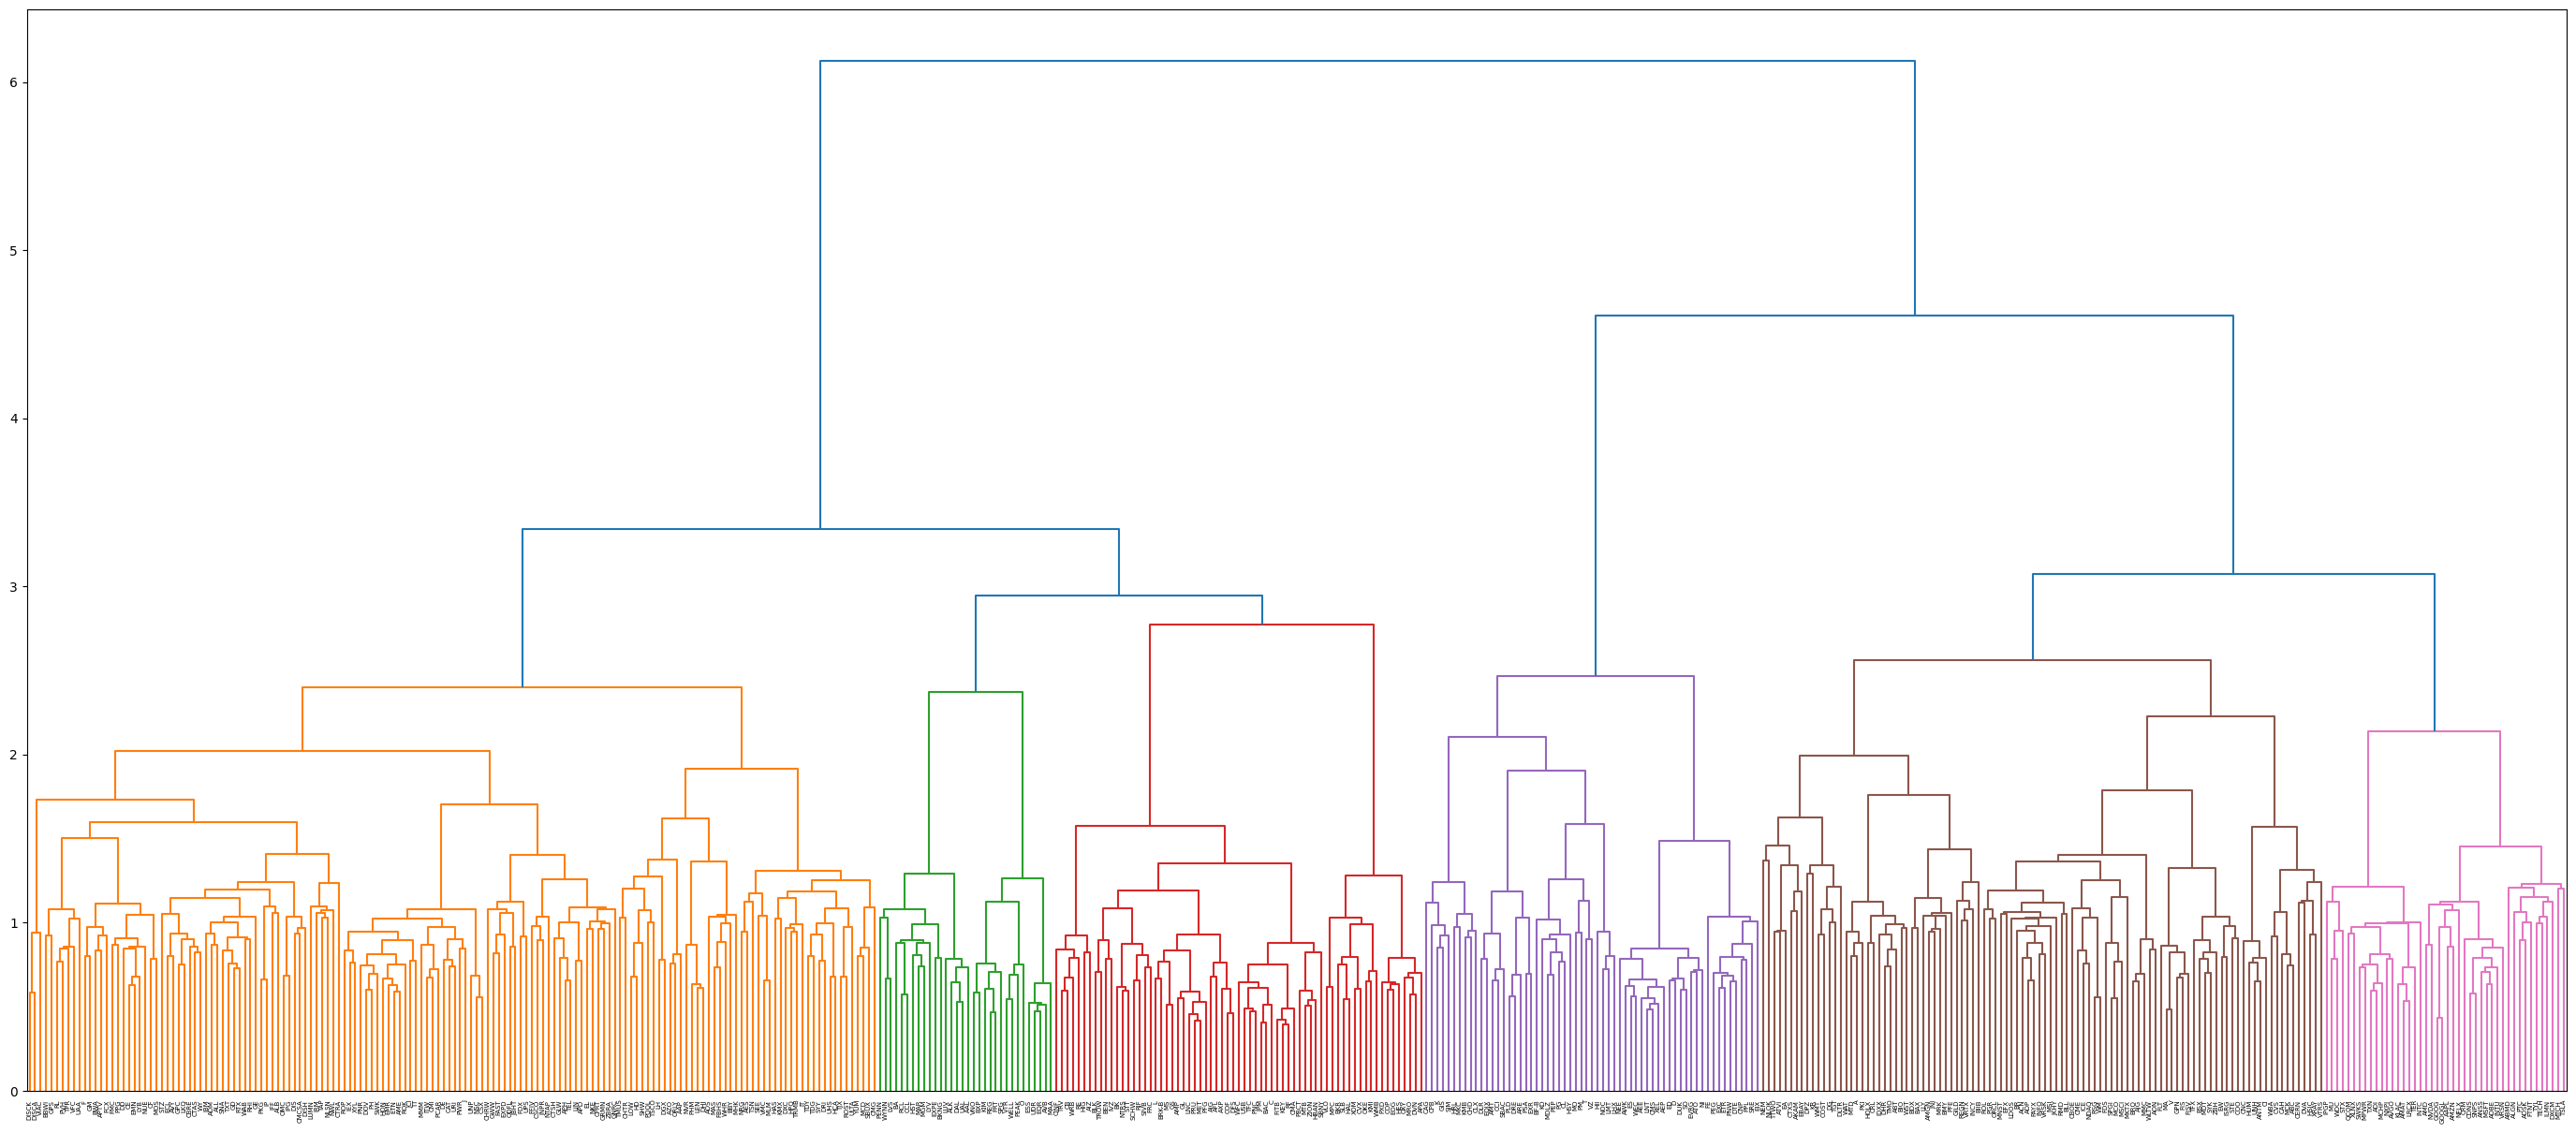

In [157]:
hacer_dendograma(ultima_ventana_american, rie_estimator.get_rie, 'ward', k_optimal_eigen_american_rie)

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [10.0, 10.0, 25.0, 25.0],
  [35.0, 35.0, 45.0, 45.0],
  [55.0, 55.0, 65.0, 65.0],
  [60.0, 60.0, 75.0, 75.0],
  [67.5, 67.5, 85.0, 85.0],
  [76.25, 76.25, 95.0, 95.0],
  [40.0, 40.0, 85.625, 85.625],
  [105.0, 105.0, 115.0, 115.0],
  [125.0, 125.0, 135.0, 135.0],
  [130.0, 130.0, 145.0, 145.0],
  [110.0, 110.0, 137.5, 137.5],
  [155.0, 155.0, 165.0, 165.0],
  [185.0, 185.0, 195.0, 195.0],
  [190.0, 190.0, 205.0, 205.0],
  [175.0, 175.0, 197.5, 197.5],
  [186.25, 186.25, 215.0, 215.0],
  [160.0, 160.0, 200.625, 200.625],
  [225.0, 225.0, 235.0, 235.0],
  [180.3125, 180.3125, 230.0, 230.0],
  [123.75, 123.75, 205.15625, 205.15625],
  [62.8125, 62.8125, 164.453125, 164.453125],
  [255.0, 255.0, 265.0, 265.0],
  [275.0, 275.0, 285.0, 285.0],
  [305.0, 305.0, 315.0, 315.0],
  [295.0, 295.0, 310.0, 310.0],
  [280.0, 280.0, 302.5, 302.5],
  [260.0, 260.0, 291.25, 291.25],
  [245.0, 245.0, 275.625, 275.625],
  [335.0, 335.0, 345.0, 345.0],
  [325.0, 325.0,

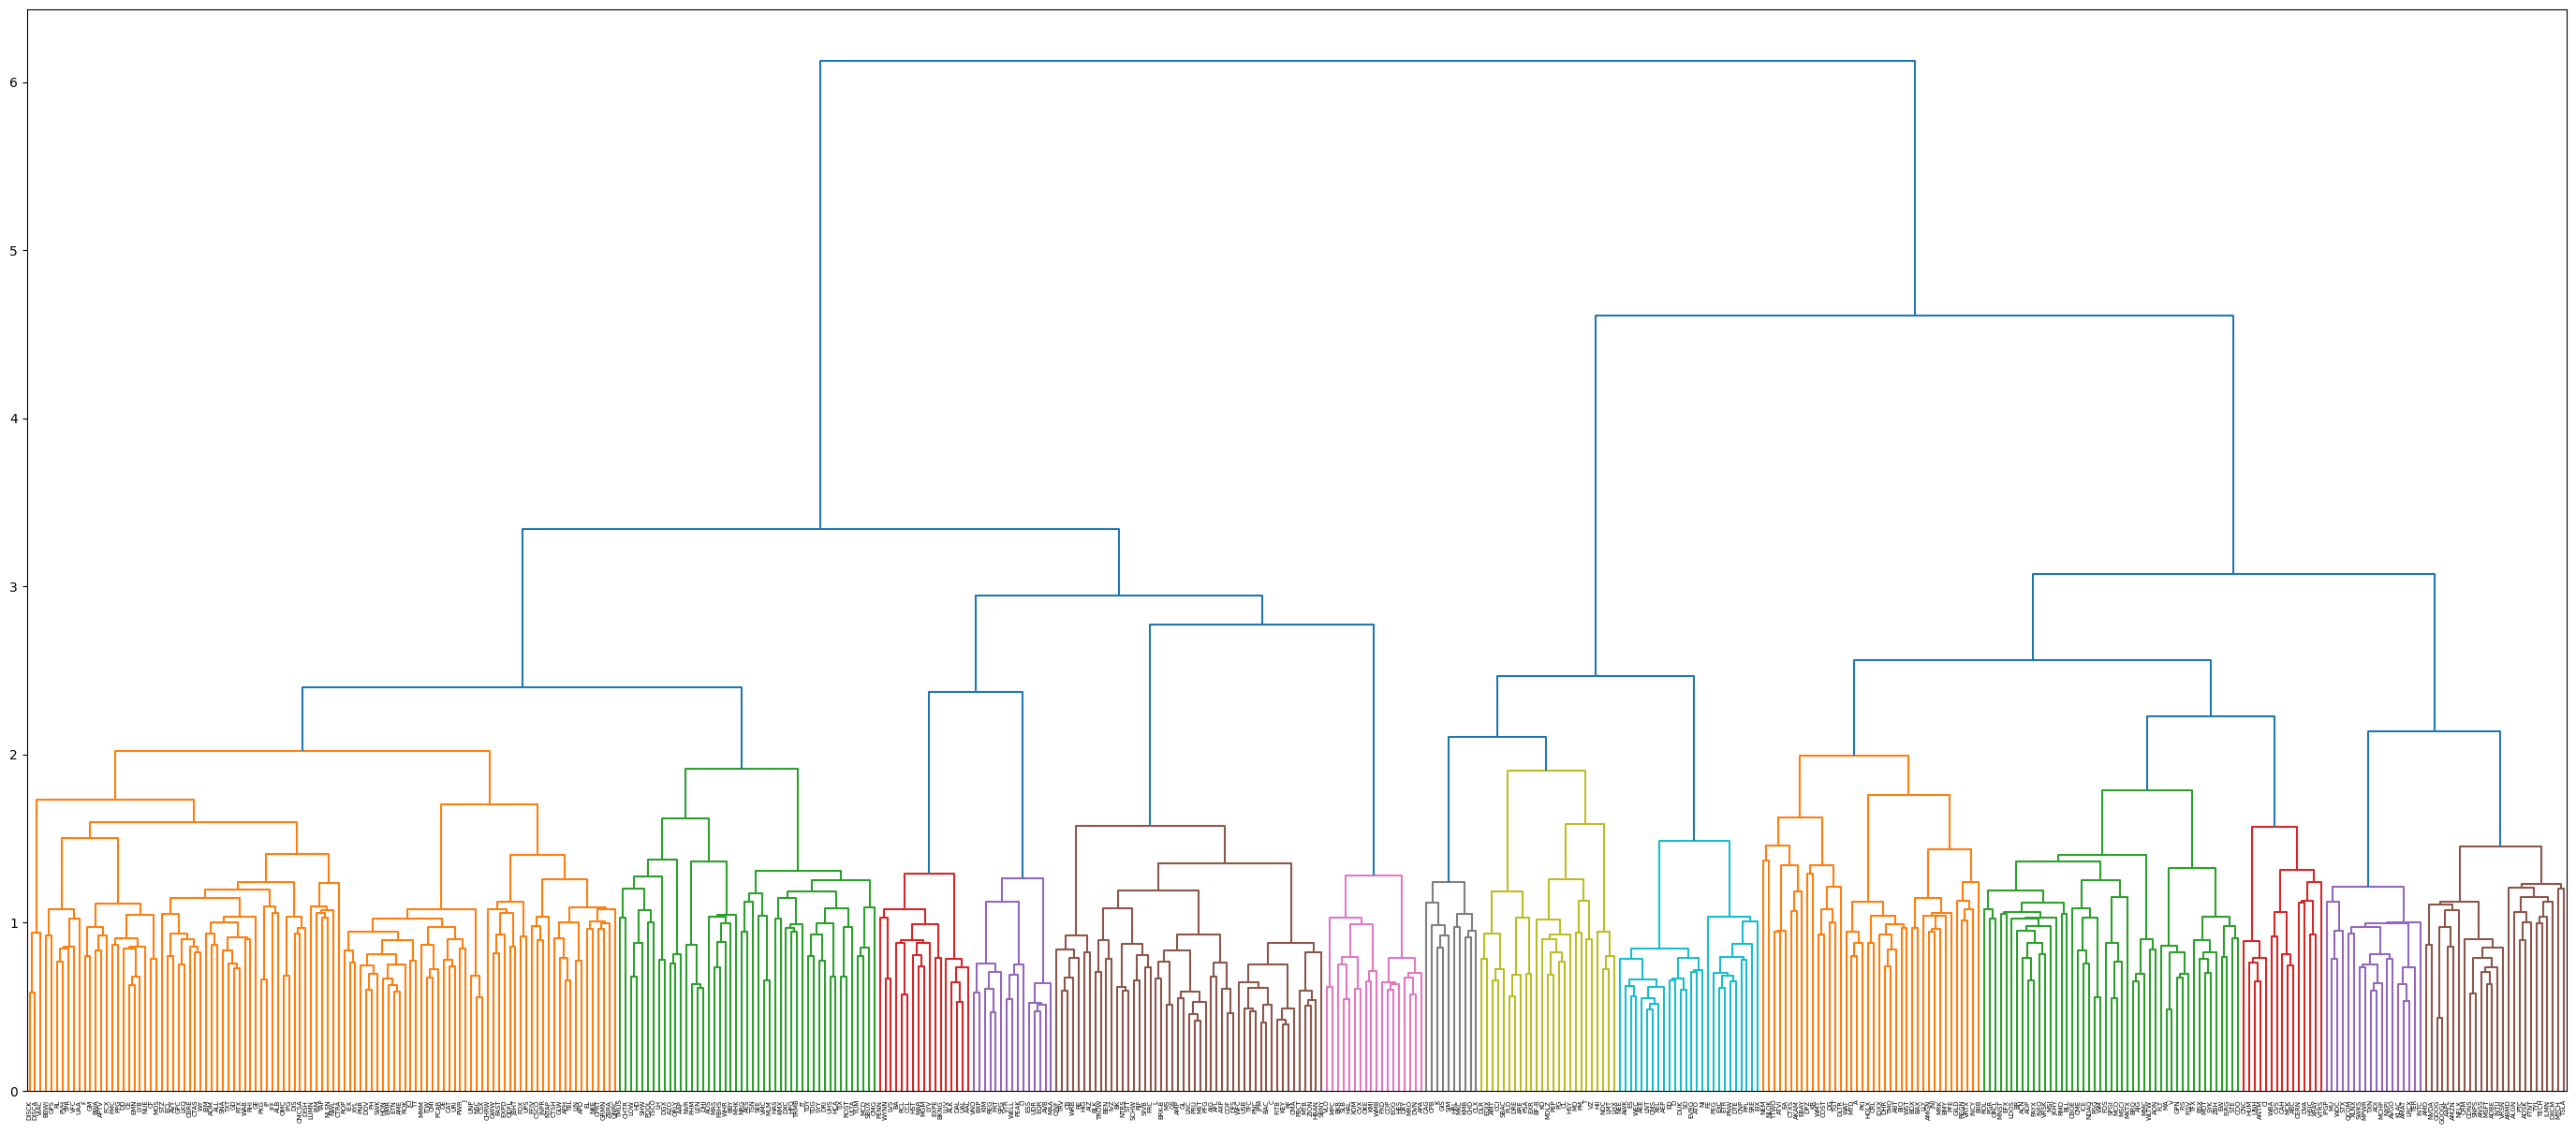

In [158]:
hacer_dendograma(ultima_ventana_american, rie_estimator.get_rie, 'ward', k_optimal_calenski_american_rie)

In [40]:
index, weights = hcaa_alocation(
    mat_X = ultima_ventana_american,
    n_clusters = k_optimal_calenski_american_rie,
    custom_corr=rie_estimator.get_rie,
    inverse_data=False,
)